# DataJoint Element for Motion Sequencing with Keypoint-MoSeq


#### **Open-source Data Pipeline for Motion Sequencing in Neurophysiology**


Welcome to the tutorial for the DataJoint Element for motion sequencing analysis. This tutorial aims to provide a comprehensive understanding of the open-source data pipeline by `element-moseq`.


![pipeline](../images/flowchart.svg)


The package is designed to seamlessly integrate the **PCA fitting**, **model fitting** through **initialization**, **fitting an AR-HMM**, and **fitting the full keypoint-SLDS model** into a data pipeline and streamline model and video management using DataJoint.


![pipeline](../images/pipeline.svg)


By the end of this tutorial, you will have a clear grasp of how to set up and integrate the `Element MoSeq` into your specific research projects and your lab.


### Prerequisites

Please see the [datajoint tutorials GitHub repository](https://github.com/datajoint/datajoint-tutorials/tree/main) proceeding.
A basic understanding of the following DataJoint concepts will be beneficial to your understanding of this tutorial:

1. The `Imported` and `Computed` tables types in `datajoint-python`.
2. The functionality of the `.populate()` method.


#### **Tutorial Overview**


- Setup
- _Activate_ the DataJoint pipeline
- _Insert_ example data into subject and session tables
- _Insert_ the keypoint data from the pose estimation and the body parts in the DataJoint pipeline
- _Fit a PCA model_ to aligned and centered keypoint coordinates and _select_ the latent dimension
- _Fit the AR-HMM and Keypoint-SLDS Models_
- _Run the inference_ task and _visualize_ the results


### **Setup**


This tutorial loads the keypoint data extracted by DeepLabCut of a single freely moving mouse in an open-field environment. The goal is to link this point tracking to pose dynamics by identifying its behavioral modules ("syllables") without human supervision. The modeling results are stored as a `.h5` file and a subdirectory of `.csv` files that contain the following information:

- Behavior modules as "syllables": the syllable label assigned to each frame (i.e. the state indexes assigned by the model)
- Centroid and heading in each frame, as estimated by the model, that capture the animal's overall position in allocentric coordinates
- Latent state: low-dimensional representation of the animal's pose in each frame. These are similar to PCA scores, and are modified to reflect the pose dynamics and noise estimates inferred by the model.

The results of this Element example can be combined with **other modalities** to create a complete customizable data pipeline for your specific lab or study. For instance, you can combine `element-moseq` with `element-deeplabcut` and `element-calcium-imaging` to characterize the neural activity along with natural sub-second rhythmicity in mouse movement.

#### Steps to Run the Element-MoSeq

The input data for this data pipeline is as follows:

- A DeepLabCut (DLC) project folder with its configuration file as `.yaml` file, video set as `.mp4`, and keypoint tracking as `.h5` files.
- Selection of the anterior, posterior, and use bodyparts for the model fitting.

This tutorial includes the keypoints example data in `example_data/inbox/dlc_project`.


Let's start this tutorial by importing the packages necessary to run the data pipeline.


In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
from pathlib import Path
import numpy as np
import glob

from element_moseq.moseq_infer import get_kpms_root_data_dir, get_kpms_processed_data_dir 
from element_interface.utils import find_full_path

If the tutorial is run in Codespaces, a private, local database server is created and made available for you. This is where we will insert and store our processed results.

Let's connect to the database server.


In [3]:
dj.conn()

[2024-03-23 00:07:56,529][INFO]: Connecting root@localhost:3306
[2024-03-23 00:07:56,567][INFO]: Connected root@localhost:3306


DataJoint connection (connected) root@localhost:3306

In [4]:
# dj.list_schemas()


In [ ]:
# dj.schema("vathes-team_devlab_mila_kpmstest_moseq_train").drop()
dj.schema("vathes-team_devlab_mila_kpmstest_moseq_infer").drop()
# dj.schema("vathes-team_devlab_mila_kpmstest_moseq_train").drop()


### **Activate the DataJoint pipeline**


This tutorial presumes that the `element-moseq` has been pre-configured and instantiated, with the database linked downstream to pre-existing `subject` and `session` tables. Please refer to the `tutorial_pipeline.py` for the source code.

Now, we will proceed to import the essential schemas required to construct this data pipeline, with particular attention to the primary components: `moseq_train` and `moseq_infer`.


In [4]:
from tests.tutorial_pipeline import lab, subject, session, moseq_train, moseq_infer

[2024-03-23 00:07:58,682][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the tables in the `moseq_train` and `moseq_infer` schemas as well as some of the upstream dependencies to `session` and `subject` schemas as a diagram.


In [ ]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(moseq_train)
    + dj.Diagram(moseq_infer)
)


As evident from the diagram, this data pipeline encompasses several tables associated with different keypoint-MoSeq components like pca, pre-fitting of AR-HMM, and full fitting of the model. A few tables, such as `subject.Subject` or `session.Session`, while important for a complete pipeline, fall outside the scope of the `element-moseq` tutorial, and will therefore, not be explored extensively here. The primary focus of this tutorial will be on the `moseq_train` and `moseq_infer` schemas.


In [ ]:
(
    dj.Diagram(moseq_train)
    + dj.Diagram(moseq_infer)
)

### **Insert example data into subject and session tables**


Let's delve into the `subject.Subject` and `session.Session` tables and include some example data.


In [ ]:
subject.Subject()

Add a new entry for a subject in the `Subject` table:


In [ ]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="F",
        subject_birth_date="2024-01-01",
        subject_description="test subject",
    ),
    skip_duplicates=True,
)

Create session keys and input them into the `Session` table:


In [ ]:
# Definition of the dictionary named "session_keys"
session_keys = [
    dict(subject="subject1", session_datetime="2024-03-15 14:04:22"),
    dict(subject="subject1", session_datetime="2024-03-16 14:43:10"),
]

# Insert this dictionary in the Session table
session.Session.insert(session_keys, skip_duplicates=True)

Confirm the inserted data:


In [ ]:
session.Session()

Let's define a `key` to use throughout the notebook:


In [ ]:
key = session_keys[0]
key

### **Insert the keypoint data from the pose estimation and the body parts in the DataJoint pipeline**


The `PoseEstimationMethod` table contains the pose estimation methods and file formats supported by the keypoint loader of `keypoint-moseq` package. In this tutorial, the keypoint input data are `.h5` files that have been obtained using `DeepLabCut`.


In [ ]:
moseq_infer.PoseEstimationMethod()

Insert keypoint input metadata into the `KeypointSet` table:


In [ ]:
moseq_train.KeypointSet.insert1(
    {
        "kpset_id": 1,
        "pose_estimation_method": "deeplabcut",
        "kpset_dir": "dlc_project",
        "kpset_desc": "Example keypoint set",
    },
    skip_duplicates=True,
)

In [ ]:
moseq_train.KeypointSet()

Add the video files in `KeypointSet.VideoFile` that will be used to fit the model:


In [ ]:
#Extract automatically all the videos in the videoset directory
videos_path = ['dlc_project/videos/21_12_10_def6a_3.top.ir.mp4',
 'dlc_project/videos/22_04_26_cage4_1_1.top.ir.mp4',
 'dlc_project/videos/21_12_10_def6a_1_1.top.ir.mp4',
 'dlc_project/videos/22_27_04_cage4_mouse2_0.top.ir.mp4',
 'dlc_project/videos/22_04_26_cage4_0.top.ir.mp4',
 'dlc_project/videos/21_11_8_one_mouse.top.ir.Mp4',
 'dlc_project/videos/21_12_2_def6b_2.top.ir.mp4',
 'dlc_project/videos/21_12_10_def6b_3.top.ir.Mp4',
 'dlc_project/videos/22_04_26_cage4_0_2.top.ir.mp4',
 'dlc_project/videos/21_12_2_def6a_1.top.ir.mp4']

#Insert the video files in the `VideoFile` table
moseq_train.KeypointSet.VideoFile.insert(
    (
        {"kpset_id": 1, "video_id": v_idx, "video_path": f}
        for v_idx, f in enumerate(videos_path)
    ),
    skip_duplicates=True,
)
moseq_train.KeypointSet.VideoFile()

Now, let's insert the body parts to use in the analysis:


In [ ]:
pca_task_key = {"kpset_id": 1, "bodyparts_id": 1}
moseq_train.Bodyparts.insert1(
    {
        **pca_task_key,
        "anterior_bodyparts": ["nose"],
        "posterior_bodyparts": ["spine4"],
        "use_bodyparts": [
            "spine4",
            "spine3",
            "spine2",
            "spine1",
            "head",
            "nose",
            "right ear",
            "left ear",
        ],
    },
    skip_duplicates=True,
)

In [ ]:
moseq_train.Bodyparts()

### **Fit a PCA model to aligned and centered keypoint coordinates and select the latent dimension**


To perform the model fitting, a PCA model and the precise dimension of the pose trajectory are required for fitting the keypoint-MoSeq.


The `PCATask` table serves the purpose of specifying the PCA task.


In [ ]:
moseq_train.PCATask()

Defining and inserting a PCA task requires:

1. Select a keypoint set
2. Select the body parts to use
3. Specify the output directory for the KPMS project


In [ ]:
moseq_train.PCATask.insert1(
    {
        **pca_task_key,
        "kpms_project_output_dir": "kpms_project_tutorial",
    },
    skip_duplicates=True,
)

In [ ]:
moseq_train.PCATask()

Before running the PCA fitting, the keypoint detections and body parts need to be formatted. The resulting coordinates and confidences scores will be used to format the data for modeling.


In [ ]:
moseq_train.PCAPrep()

Populate the `PCAPrep` table will:

1. Create the output directory, if it does not exist, with the kpms default `config.yml` file that contains the default values from the pose estimation
2. Generate a copy as `dj_config.yml` and update it with both the video directory and the bodyparts
3. Create and store the keypoint coordinates and confidences scores to format the data for the PCA fitting
4. Calculate the average frame rate of the videoset chosen to train the model. This will be useful to calculate the kappa value in the next step.


In [ ]:
moseq_train.PCAPrep.populate()

In [ ]:
moseq_train.PCAPrep()

The `PCAFit` computation will format the aligned and centered keypoint coordinates, fit a PCA model, and save it as `pca.p` file in the output directory.


In [ ]:
moseq_train.PCAFit.populate()

In [ ]:
moseq_train.PCAFit()

However, we still need to determine the specific dimension of the pose trajectory to utilize for fitting the keypoint-MoSeq model. A helpful guideline is to consider the number of dimensions required to explain 90% of the variance, or a maximum of 10 dimensions, whichever is lower.

The computation of `LatentDimension` will automatically identify the components that explain 90% of the variance, aiding the user in making the final decision regarding an appropriate latent dimension for model fitting.


In [ ]:
moseq_train.LatentDimension.populate()

In [ ]:
moseq_train.LatentDimension()

To aid the user in selecting the latent dimensions for model fitting, two plots are created below: a cumulative scree plot and a visualization of each Principal Component (PC). In this visualization, translucent nodes/edges represent the mean pose, while opaque nodes/edges represent a perturbation in the direction of the PC.
The plots are stored in the output directory.


In [ ]:
# Generate and store plots for the user to choose the latent dimensions in the next step
from keypoint_moseq import load_pca, plot_scree, plot_pcs
from element_moseq.readers.kpms_reader import load_kpms_dj_config

kpms_project_output_dir = (moseq_train.PCATask & pca_task_key).fetch1("kpms_project_output_dir")
kpms_project_output_dir = get_kpms_processed_data_dir()/kpms_project_output_dir

kpms_dj_config = load_kpms_dj_config(kpms_project_output_dir.as_posix(), check_if_valid=False, build_indexes=False)
pca = load_pca(kpms_project_output_dir.as_posix())

plot_scree(pca, project_dir=kpms_project_output_dir.as_posix())
plot_pcs(pca, project_dir=kpms_project_output_dir.as_posix(), **kpms_dj_config)

The chosen dimension for the next steps in the analysis will be `latent dimension = 4`.


### **Fit the AR-HMM and keypoint-SLDS Models**


The pre-fitting and full-fitting processes for the KPMS Model involve the following steps:

1. **Initialization**: Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA
2. **Fitting an AR-HMM**: AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling
3. **Fitting the full model**: All parameters, including both AR-HMM and centroid, heading, noise-estimates, and continuous latent states (i.e., pose trajectories) are iteratively updated through Gibbs sampling. This step is particularly useful for noisy data.


In [ ]:
dj.Diagram(moseq_train)

For the pre-fitting step (fitting an AR-HMM), a pre-fitting task needs to be defined and inserted:


In [ ]:
moseq_train.PreFitTask()

This task requires the following inputs:

1. The keypoint set, body parts, and latent dimension (extracted in the section above).
2. A kappa value for the model pre-fitting.
3. The number of iterations for the model pre-fitting.


**Kappa hyperparameter**:
An important decision for the user is to adjust the kappa hyperparameter to achieve the desired distribution of syllable durations. Higher values of kappa result in longer syllables.

As a reference, let's choose a kappa value that yields a median syllable duration of 12 frames (400 ms), a duration recommended for rodents.

During the model pre-fitting, it's advisable to explore different values of kappa (`kappa_range`) until the syllable durations stabilize.


In [ ]:
fps = (moseq_train.PCAPrep & pca_task_key).fetch1("average_frame_rate")
kappa_min = (12 / fps) * 1000 #ms
kappa_max = 1e4 #ms 
kappa_range = np.logspace(np.log10(kappa_min), np.log10(kappa_max), num=3)
kappa_range = np.round(kappa_range).astype(int)
print(['kappa = {:.2f} ms'.format(x) for x in kappa_range])


**Number of Iterations**: Typically, stabilizing the syllable duration requires 10-50 iterations during the model pre-fitting stage, while stabilizing the syllable sequence after setting kappa may take 200-500 iterations during the model full-fitting stage.

For tutorial purposes, we will opt for a very low number of iterations (`num_iterations = 5`) to ensure the notebook runs quickly, taking just a few minutes.


Thus, we will insert different entries (`prefitting_keys`) in the `PreFittingTask` with various kappa values until the target syllable time-scale is achieved.


In [ ]:
moseq_train.PreFitTask.heading

In [ ]:
prefit_keys = [{
    **pca_task_key,
    'pre_latent_dim': 4,
    'pre_kappa': int(i),
    'pre_num_iterations': 5,
    'pre_fitting_desc': f"Testing Pre-fitting task {c}"
} for c, i in enumerate(kappa_range, start=1)]

prefit_keys

In [ ]:
moseq_train.PreFitTask.insert(prefit_keys, skip_duplicates=True)

Show the contents of the `PreFittingTask` table.


In [ ]:
moseq_train.PreFitTask()

When populating the `PreFit` table, the fitting of different AR-HMM models for each kappa defined in the `PreFittingTask` will be automatically computed. This step will take a few minutes.


In [ ]:
moseq_train.PreFit.populate()

In [ ]:
moseq_train.PreFit()

Now we can define a `FullFittingTask` based on the selected `latent_dimension = 4`, the chosen `kappa = 10000`, and `num_iterations = 5` based on the previous exploration.

Again and for tutorial purposes, we will opt for a very low number of iterations (`num_iterations = 5`) to ensure the notebook runs quickly, taking just a few minutes.


In [ ]:
moseq_train.FullFitTask.heading

In [ ]:
# modify kappa to maintain the desired syllable time-scale
full_fit_key = ({**pca_task_key,
                      'full_latent_dim': 4,
                      'full_kappa': 10000,
                      'full_num_iterations':5,
                      'full_fitting_desc':"Fitting task with kappa = 10000 ms"
})

moseq_train.FullFitTask.insert1(full_fit_key, skip_duplicates=True)                                 

Let's add a second FullFitting task:


In [ ]:
full_fitting_key_2 = ({**pca_task_key,
                      'full_latent_dim': 4,
                      'full_kappa': 5000,
                      'full_num_iterations':5,
                      'full_fitting_desc':"Fitting task with kappa = 5000 ms"
})

moseq_train.FullFitTask.insert1(full_fitting_key_2, skip_duplicates=True)    

In [ ]:
moseq_train.FullFitTask()

In [ ]:
moseq_train.FullFit.populate()

In [ ]:
moseq_train.FullFit()

### **Run the inference task and visualize the results**


The models along with their pertinent information will be registered in the DataJoint pipeline as follows:


In [ ]:
model_name, latent_dim, kappa = (moseq_train.FullFit & "full_kappa = 10000").fetch1("model_name","full_latent_dim","full_kappa")
moseq_infer.Model.insert1({
    "model_id": 1,
    "model_name": "model 1",
    "model_dir" : model_name,
    "latent_dim" :latent_dim,
    "kappa" : kappa}, skip_duplicates=True)

In [ ]:
model_name, latent_dim, kappa = (moseq_train.FullFit & "full_kappa = 5000").fetch1("model_name","full_latent_dim","full_kappa")
moseq_infer.Model.insert1({
    "model_id":2,
    "model_name": "model 2",
    "model_dir" : model_name,
    "latent_dim" :latent_dim,
    "kappa" : kappa}, skip_duplicates=True)

We can check the `Model` table to confirm that the new models have been registered:


In [ ]:
moseq_infer.Model()

#### Optional: Model comparison to select a model

The expected marginal likelihood (EML) score can be used to rank models. The model with the highest EML score can then be selected for further analysis.


In [ ]:
model_names = (moseq_train.FullFit).fetch("model_name")

checkpoint_paths = []
for model_name in model_names:
    checkpoint_paths.append(get_kpms_processed_data_dir()/Path(model_name)/"checkpoint.h5")
checkpoint_paths    

from keypoint_moseq import expected_marginal_likelihoods, plot_eml_scores
eml_scores, eml_std_errs = expected_marginal_likelihoods(checkpoint_paths=checkpoint_paths)
best_model = model_names[np.argmax(eml_scores)]
print(f"Best model: {best_model}")

plot_eml_scores(eml_scores, eml_std_errs, model_names)

Thus, we choose the best ranked model for the inference task:


In [ ]:
best_model_id = (moseq_infer.Model & "model_dir = '{}'".format(best_model)).fetch1("model_id")
print(f"Best model id: {best_model_id}")

For tutorial purposes, we'll utilize the same video set (`videos_path`) employed for modeling training as the video set for inference. This will be incorporated into the `VideoRecording` table as well.


In [ ]:
recording_key = {
    **key, 
    "recording_id": 1, 
    }
moseq_infer.VideoRecording.insert1({**recording_key,
                                    "device": "Camera1"},
                                  skip_duplicates=True)

In [ ]:
for idx,video_name in enumerate(videos_path):
    moseq_infer.VideoRecording.File.insert1(dict(
                                **recording_key,
                                file_id = idx,
                                file_path = video_name),
                                skip_duplicates=True)

In [ ]:
moseq_infer.VideoRecording * moseq_infer.VideoRecording.File

The `InferenceTask` table serves the purpose of specifying an inference task:


In [ ]:
moseq_infer.InferenceTask.heading


Defining and inserting a inference task requires:

1. Define the subject and session datetime
2. Define the video recording
3. Define the pose estimation method used for the video recording
4. Choose a model
5. Specify the output directory and any optional parameters


In [ ]:
moseq_infer.InferenceTask.insert1({
        **recording_key,
        "model_id"   : best_model_id,
        "pose_estimation_method": "deeplabcut",
        "keypointset_dir": "dlc_project/videos",
        "inference_output_dir": "inference_output",
        "inference_desc": "Inference task for the tutorial",
        "num_iterations": 5, # Limited iterations for tutorial purposes.
}, skip_duplicates=True)

In [ ]:
moseq_infer.InferenceTask()

Populating the `Inference` table will automatically extract learned states of the model (syllables, latent_state, centroid, and heading) and stored in the inference output directory together with visualizations and grid movies. The following function will take a few minutes.


Applying model: 100%|█████████████████████| 5/5 [01:45<00:00, 21.00s/it]


Saved results to /Users/milagros/Documents/datajoint-elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_22-23_25_04/inference_
output/results.h5


Saving to csv: 100%|████████████████████| 10/10 [00:01<00:00,  6.80it/s]


Saving trajectory plots to /Users/milagros/Documents/datajoint-elements/element-moseq/data/outbox/kpms_project_tutorial/2024_03_22-23_25_04/inference_output/trajectory_plots


Generating trajectory plots: 100%|██████| 44/44 [00:09<00:00,  4.72it/s]


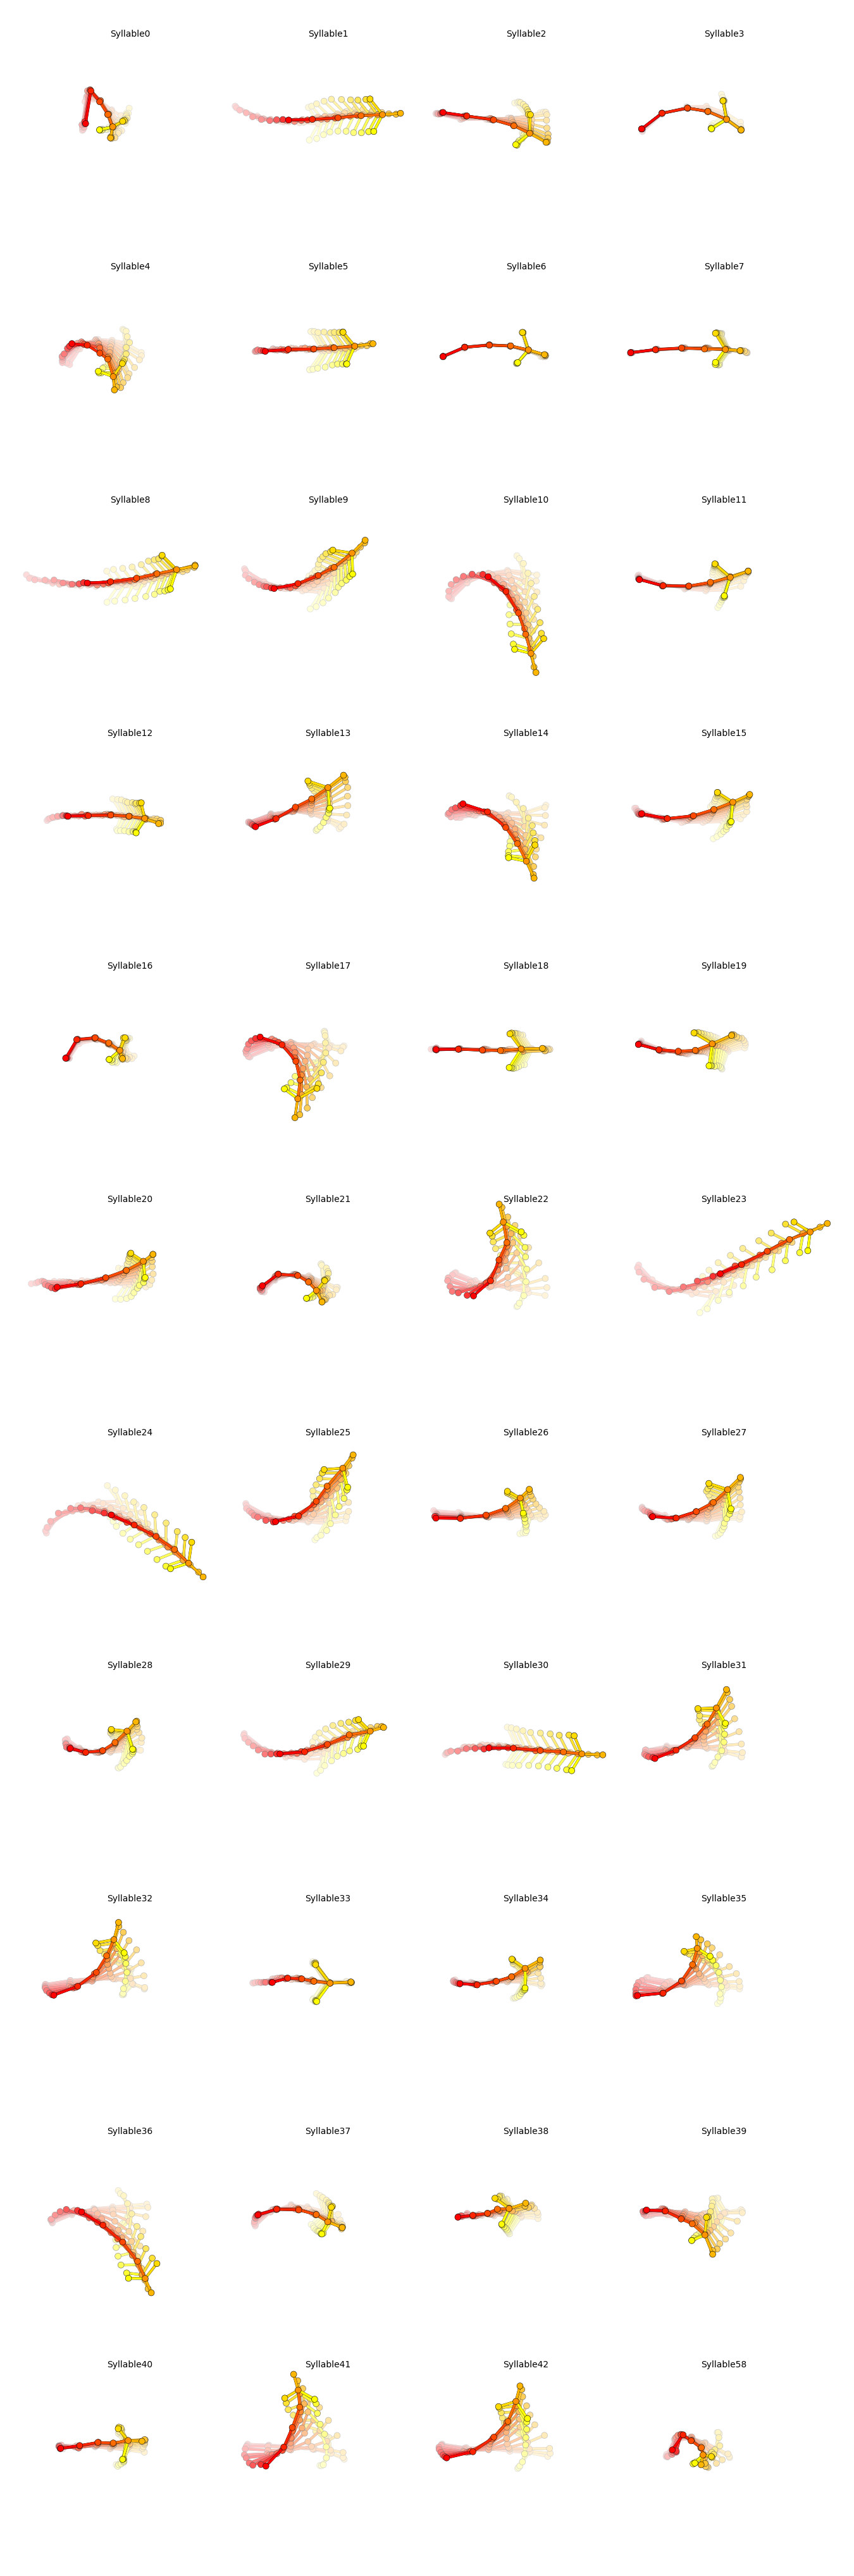

TypeError: keypoint_moseq.viz.generate_grid_movies() got multiple values for keyword argument 'video_dir'

In [5]:
moseq_infer.Inference.populate()

In [ ]:
moseq_infer.Inference()

The `MotionSequence` table contains the results for the inference (syllables, latent_state, centroid, and heading):


In [ ]:
moseq_infer.Inference.MotionSequence()

The `GridMoviesSampledInstances` table contains the sampled instances for the grid movies. The sampled instances is a dictionary mapping syllables to lists of instances shown in each grid movie (in row-major order).


In [ ]:
moseq_infer.Inference.GridMoviesSampledInstances()

In [ ]:
instance_syllable_0 = (moseq_infer.Inference.GridMoviesSampledInstances & "syllable = 0").fetch1("instances")
instance_syllable_0

The instance for syllable 0 is specified as a tuple with the video name, start frame and end frame.


### Summary


Following this tutorial, we have:

- Covered the essential functionality of `element-moseq`
- Acquired the skills to load the keypoint data and insert metadata into the pipeline
- Learned how to fit a PCA, run the AR-HMM fitting and the Keypoint-SLDS fitting
- Executed and ingested results of the motion sequencing analysis with Keypoint-MoSeq
- Visualized and stored the results


#### Documentation and DataJoint tutorials


- Detailed [documentation on `element-moseq`](https://datajoint.com/docs/elements/element-moseq/0.1/)
- [General `DataJoint-Python` interactive tutorials](https://github.com/datajoint/datajoint-tutorials), covering fundamentals, such as table tiers, query operations, fetch operations, automated computations with the make function, and more.
- [Documentation for `DataJoint-Python`](https://datajoint.com/docs/core/datajoint-python/0.14/)
